# Look at the overview scans
Let's see what we did there.

In [1]:
import platform
import os
import glob
import pandas
import imageio
import numpy
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
import seaborn
import dask
import dask_image.imread
from dask.distributed import Client
client = Client()
# Then go to http://localhost:8787/status
from numcodecs import Blosc
import skimage
from tqdm import notebook

In [2]:
print('You can seee what DASK is doing at "http://localhost:%s/status"' % client.scheduler_info()['services']['dashboard'])

You can seee what DASK is doing at "http://localhost:8787/status"


In [3]:
# # Ignore warnings in the notebook
# import warnings
# warnings.filterwarnings("ignore")

In [4]:
# Set up figure defaults
plt.rc('image', cmap='gray', interpolation='nearest')  # Display all images in b&w and with 'nearest' interpolation
plt.rcParams['figure.figsize'] = (16, 9)  # Size up figures a bit

In [5]:
# Setup scale bar defaults
plt.rcParams['scalebar.location'] = 'lower right'
plt.rcParams['scalebar.frameon'] = False
plt.rcParams['scalebar.color'] = 'white'

In [6]:
# Display all plots identically
lines = 3
# And then do something like
# plt.subplot(lines, numpy.ceil(len(Data) / float(lines)), c + 1)

In [7]:
# Different locations if running either on Linux or Windows
FastSSD = False
# to speed things up significantly
if 'Linux' in platform.system():
    if FastSSD:
        BasePath = os.path.join(os.sep, 'media', 'habi', 'Fast_SSD')
    else:
        BasePath = os.path.join(os.sep, 'home', 'habi', '1272')
else:
    if FastSSD:
        BasePath = os.path.join('F:\\')
    else:
        if 'anaklin' in platform.node():
            BasePath = os.path.join('S:\\')
        else:
            BasePath = os.path.join('D:\\Results')
Root = os.path.join(BasePath, 'EAWAG')
print('We are loading all the data from %s' % Root)

We are loading all the data from D:\Results\EAWAG


In [8]:
def get_pixelsize(logfile):
    """Get the pixel size from the scan log file"""
    with open(logfile, 'r') as f:
        for line in f:
            if 'Image Pixel' in line and 'Scaled' not in line:
                pixelsize = float(line.split('=')[1])
    return(pixelsize)

In [9]:
def get_projectionsize(logfile):
    """How big did we set the camera?"""
    with open(logfile, 'r') as f:
        for line in f:
            if 'Number Of Rows' in line:
                y = int(line.split('=')[1])
            if 'Number Of Columns' in line:
                x = int(line.split('=')[1])                
    return(x*y)

In [10]:
def get_filter(logfile):
    """Get the filter we used whole scanning from the scan log file"""
    with open(logfile, 'r') as f:
        for line in f:
            if 'Filter=' in line:
                whichfilter = line.split('=')[1].strip()
    return(whichfilter)

In [11]:
def get_exposuretime(logfile):
    """Get the exposure time size from the scan log file"""
    with open(logfile, 'r') as f:
        for line in f:
            if 'Exposure' in line:
                exposuretime = int(line.split('=')[1])
    return(exposuretime)

In [12]:
def get_ringartefact(logfile):
    """Get the ring artefact correction from the  scan log file"""
    with open(logfile, 'r') as f:
        for line in f:
            if 'Ring Artifact' in line:
                ringartefactcorrection = int(line.split('=')[1])
    return(ringartefactcorrection)

In [13]:
def get_reconstruction_grayvalue(logfile):
    """How did we map the brightness of the reconstructions?"""
    with open(logfile, 'r') as f:
        for line in f:
            if 'Maximum for' in line:
                grayvalue = float(line.split('=')[1])
    return(grayvalue)

In [14]:
def get_beamhardening(logfile):
    """Get the beamhardening correction from the  scan log file"""
    with open(logfile, 'r') as f:
        for line in f:
            if 'Hardening' in line:
                beamhardeningcorrection = int(line.split('=')[1])
    return(beamhardeningcorrection)

In [15]:
def get_rotationstep(logfile):
    """Get the rotation step from the scan log file"""
    with open(logfile, 'r') as f:
        for line in f:
            if 'Rotation Step' in line:
                rotstep = float(line.split('=')[1])
    return(rotstep)

In [16]:
def get_frameaveraging(logfile):
    """Get the frame averaging from the scan log file"""
    with open(logfile, 'r') as f:
        for line in f:
            if 'Averaging' in line:
                avg = line.split('=')[1]
    return(avg)

In [17]:
def get_machine(logfile):
    """Get the machine we used to scan"""
    with open(logfile, 'r') as f:
        for line in f:
            if 'Scanner' in line:
                machine = line.split('=')[1].strip()
    return(machine)

In [18]:
def get_scantime(logfile):
    """How long did we scan?"""
    with open(logfile, 'r') as f:
        for line in f:
            if 'Scan duration' in line:
                time = line.split('=')[1].strip()
    return(pandas.to_timedelta(time))

In [19]:
def get_scandate(logfile, verbose=False):
    """When did we scan the fish?"""
    with open(logfile, 'r') as f:
        for line in f:
            if 'Study Date and Time' in line:
                if verbose:
                    print('Found "date" line: %s' % line.strip())
                datestring = line.split('=')[1].strip().replace('  ', ' ')
                if verbose:
                    print('The date string is: %s' % datestring)
                date = pandas.to_datetime(datestring , format='%d %b %Y %Hh:%Mm:%Ss')
                if verbose:
                    print('Parsed to: %s' % date)
                (date)
    return(date)

In [20]:
def get_git_hash():
    '''
    Get the current git hash from the repository.
    Based on http://stackoverflow.com/a/949391/323100 and
    http://stackoverflow.com/a/18283905/323100
    '''
    from subprocess import Popen, PIPE
    import os
    gitprocess = Popen(['git',
                        '--git-dir',
                        os.path.join(os.getcwd(), '.git'),
                        'rev-parse',
                        '--short',
                        '--verify',
                        'HEAD'],
                       stdout=PIPE)
    (output, _) = gitprocess.communicate()
    return output.strip().decode("utf-8")

In [21]:
# # Make directory for output
# OutPutDir = os.path.join(os.getcwd(), 'Output', get_git_hash())
# print('We are saving all the output to %s' % OutPutDir)
# os.makedirs(OutPutDir, exist_ok=True)

In [22]:
# Make us a dataframe for saving all that we need
Data = pandas.DataFrame()

In [23]:
# Get *all* log files
# Sort them by time, not name
Data['LogFile'] = [f for f in sorted(glob.glob(os.path.join(Root, '**', '*.log'), recursive=True), key=os.path.getmtime)]

In [24]:
# Get all folders
Data['Folder'] = [os.path.dirname(f) for f in Data['LogFile']]

In [25]:
# Get rid of all non-rec logfiles
for c, row in Data.iterrows():
    if 'rec' not in row.Folder:
        Data.drop([c], inplace=True)
# Reset dataframe to something that we would get if we only would have loaded the 'rec' files
Data = Data.reset_index(drop=True)

In [26]:
# Generate us some meaningful colums
Data['Fish'] = [l[len(Root)+1:].split(os.sep)[0] for l in Data['LogFile']]
Data['Scan'] = [l[len(Root)+1:].split(os.sep)[1] for l in Data['LogFile']]

In [27]:
# Get the file names of the reconstructions
Data['Reconstructions'] = [sorted(glob.glob(os.path.join(f, '*rec0*.png'))) for f in Data['Folder']]
Data['Number of reconstructions'] = [len(r) for r in Data.Reconstructions]

In [28]:
# Drop samples which have not been reconstructed yet
# Based on https://stackoverflow.com/a/13851602
for c,row in Data.iterrows():
    if not row['Number of reconstructions']:
        print('%s contains no PNG files, we remove it from our data temporarily' % row.Folder)
Data = Data[Data['Number of reconstructions'] > 0]
Data.reset_index(drop=True, inplace=True)
print('We have %s folders with reconstructions' % (len(Data)))

We have 39 folders with reconstructions


In [29]:
# Get parameters to doublecheck from logfiles
Data['Voxelsize'] = [get_pixelsize(log) for log in Data['LogFile']]
Data['Filter'] = [get_filter(log) for log in Data['LogFile']]
Data['Exposuretime'] = [get_exposuretime(log) for log in Data['LogFile']]
Data['Scanner'] = [get_machine(log) for log in Data['LogFile']]
Data['Averaging'] = [get_frameaveraging(log) for log in Data['LogFile']]
Data['ProjectionSize'] = [get_projectionsize(log) for log in Data['LogFile']]
Data['RotationStep'] = [get_rotationstep(log) for log in Data['LogFile']]
Data['CameraWindow'] = [round((ps ** 0.5)/100)*100  for ps in Data['ProjectionSize']]
Data['Grayvalue'] = [get_reconstruction_grayvalue(log) for log in Data['LogFile']]
Data['RingartefactCorrection'] = [get_ringartefact(log) for log in Data['LogFile']]
Data['BeamHardeningCorrection'] = [get_beamhardening(log) for log in Data['LogFile']]
Data['Scan date'] = [get_scandate(log) for log in Data['LogFile']]
Data['Scan time'] = [get_scantime(log) for log in Data['LogFile']]

In [30]:
# https://www.geeksforgeeks.org/iterating-over-rows-and-columns-in-pandas-dataframe/
columns = list(Data)
columns.remove('Folder') 
columns.remove('Fish')
columns.remove('LogFile')
columns.remove('Reconstructions')
columns.remove('Number of reconstructions')
columns.remove('Grayvalue')
columns.remove('Scan time')
print(columns)
for col in columns:
    print(col)
    print(Data[col].unique())
    print(80*'-')    

['Scan', 'Voxelsize', 'Filter', 'Exposuretime', 'Scanner', 'Averaging', 'ProjectionSize', 'RotationStep', 'CameraWindow', 'RingartefactCorrection', 'BeamHardeningCorrection', 'Scan date']
Scan
['rec' 'stack' 'jaw' 'jaw_v1' 'W' 'P' 'pharynx' 'head_18um' 'head_13um'
 'head_30um' 'rec_22um' 'rec_13um' 'full_188um' 'rec_stuck']
--------------------------------------------------------------------------------
Voxelsize
[  5.000014   5.001124   5.000018   2.999931  17.999866  13.127366
  30.000008  21.999992  13.120329 188.212   ]
--------------------------------------------------------------------------------
Filter
['Al 0.5mm' 'Al 0.25mm' 'No Filter' 'Al 1mm']
--------------------------------------------------------------------------------
Exposuretime
[1162 2888 3254 1985  711 4133 1062 1878 1500  450  445  280  750  294]
--------------------------------------------------------------------------------
Scanner
['SkyScan1272' 'SkyScan2214']
---------------------------------------------------

In [31]:
# Check voxel sizes (*rounded* to two after-comma values)
# If different, spit out which values
roundto = 2
if len(Data['Voxelsize'].round(roundto).unique()) > 1:
    print('We scanned all datasets with %s different voxel sizes' % len(Data['Voxelsize'].round(roundto).unique()))
    for vs in sorted(Data['Voxelsize'].round(roundto).unique()):
        print('-', vs, 'um for ', end='')
        for c, row in Data.iterrows():
            if float(vs) == round(row['Voxelsize'], roundto):
                print(os.path.join(row['Fish'], row['Scan']), end=', ')
        print('')
else:
    print('We scanned all datasets with equal voxel size, namely %s um.' % float(Data['Voxelsize'].round(roundto).unique()))

We scanned all datasets with 8 different voxel sizes
- 3.0 um for Teeth\W, Teeth\W, Teeth\P, Teeth\P, 
- 5.0 um for 14295\rec, 103908\stack, 106985\rec, IG96\rec, 103754\rec, 14298\rec, 103908\jaw, TJ3\jaw_v1, 14269\rec, IG92\rec, KAT13\jaw, KAT13\pharynx, 104016\jaw, 104016\pharynx, KC31\jaw, KC31\pharynx, TJ3\pharynx, 21322\jaw, TJ3\jaw, 131282\pharynx, 131282\jaw, 103635\pharynx, 103778\jaw, 103778\pharynx, 103635\jaw, 
- 13.12 um for 161543\rec, 13115\rec_13um, 11045\rec, 103375\rec_stuck, 14128\rec, 
- 13.13 um for 10628\head_13um, 
- 18.0 um for 10628\head_18um, 
- 22.0 um for 13115\rec_22um, 
- 30.0 um for 161543\head_30um, 
- 188.21 um for 10628\full_188um, 


In [32]:
if len(Data['Grayvalue'].unique()) > 1:
    print('We reconstructed the datasets with different maximum gray values, namely')
    for gv in Data['Grayvalue'].unique():
        print(gv, 'for Samples ', end='')
        for c, row in Data.iterrows():
            if float(gv) == row['Grayvalue']:
                print(os.path.join(row['Fish'], row['Scan']), end=', ')
        print('')
else:
    print('We reconstructed all datasets with equal maximum gray value, namely %s.' % Data['Grayvalue'].unique()[0])

We reconstructed the datasets with different maximum gray values, namely
0.143809 for Samples 14295\rec, 
0.13 for Samples 103908\stack, 
0.125004 for Samples 106985\rec, 
0.133082 for Samples IG96\rec, 
0.103898 for Samples 103754\rec, 
0.106857 for Samples 14298\rec, 
0.11886 for Samples 103908\jaw, 
0.118008 for Samples TJ3\jaw_v1, 
0.089655 for Samples 14269\rec, 
0.277898 for Samples Teeth\W, 
0.638647 for Samples Teeth\W, 
0.326348 for Samples Teeth\P, 
0.721731 for Samples Teeth\P, 
0.135014 for Samples IG92\rec, 
0.186443 for Samples KAT13\jaw, 
0.131861 for Samples KAT13\pharynx, 
0.111685 for Samples 104016\jaw, 
0.225172 for Samples 104016\pharynx, 
0.091627 for Samples KC31\jaw, 
0.185396 for Samples KC31\pharynx, 
0.199813 for Samples TJ3\pharynx, 
0.100226 for Samples 21322\jaw, 
0.172262 for Samples TJ3\jaw, 
0.156964 for Samples 131282\pharynx, 
0.13304 for Samples 131282\jaw, 
0.150308 for Samples 103635\pharynx, 
0.033864 for Samples 10628\head_18um, 
0.127411 for Sam

In [33]:
# Data.sort_values(by='Scan date', inplace=True)

In [53]:
Data[['Fish', 'Scan',
      'Voxelsize', 'Scanner',
      'Scan date', 'CameraWindow', 'RotationStep', 'Averaging', 'Scan time', ]]

Fish        Scan   Voxelsize      Scanner           Scan date  \
0    14295         rec    5.000014  SkyScan1272 2020-10-26 12:58:57   
1   103908       stack    5.000014  SkyScan1272 2020-11-13 14:29:52   
2   106985         rec    5.001124  SkyScan1272 2020-11-16 23:53:27   
3     IG96         rec    5.000018  SkyScan1272 2020-11-19 17:39:48   
4   103754         rec    5.000018  SkyScan1272 2020-11-20 06:25:50   
5    14298         rec    5.000018  SkyScan1272 2020-11-17 18:22:34   
6   103908         jaw    5.000014  SkyScan1272 2020-11-03 12:34:39   
7      TJ3      jaw_v1    5.000014  SkyScan1272 2020-10-26 11:39:02   
8    14269         rec    5.000018  SkyScan1272 2020-11-20 17:03:10   
9    Teeth           W    2.999931  SkyScan1272 2020-12-10 13:19:28   
10   Teeth           W    2.999931  SkyScan1272 2020-12-10 10:30:18   
11   Teeth           P    2.999931  SkyScan1272 2020-12-10 14:59:13   
12   Teeth           P    2.999931  SkyScan1272 2020-12-10 16:46:29   
13    IG92         rec    5.000018  SkyScan1272 2021-01-29 17:31:09   
14   KAT13         jaw    5.000014  SkyScan1272 2021-02-03 10:58:47   
15   KAT13     pharynx    5.000014  SkyScan1272 2021-02-03 13:17:33   
16  104016         jaw    5.000014  SkyScan1272 2021-02-04 11:21:23   
17  104016     pharynx    5.000014  SkyScan1272 2021-02-04 13:30:11   
18    KC31         jaw    5.000018  SkyScan1272 2021-01-29 00:39:37   
19    KC31     pharynx    5.000014  SkyScan1272 2021-02-01 13:22:52   
20     TJ3     pharynx    5.000014  SkyScan1272 2021-02-01 11:05:12   
21   21322         jaw    5.000014  SkyScan1272 2020-09-28 16:12:57   
22     TJ3         jaw    5.000018  SkyScan1272 2021-01-28 15:14:44   
23  131282     pharynx    5.000014  SkyScan1272 2021-02-05 13:44:12   
24  131282         jaw    5.000014  SkyScan1272 2021-02-05 11:39:26   
25  103635     pharynx    5.000014  SkyScan1272 2021-02-08 14:24:12   
26   10628   head_18um   17.999866  SkyScan2214 2021-02-10 12:47:54   
27  103778         jaw    5.000014  SkyScan1272 2021-02-10 12:49:28   
28  103778     pharynx    5.000014  SkyScan1272 2021-02-10 14:48:26   
29   10628   head_13um   13.127366  SkyScan2214 2021-02-10 13:36:01   
30  103635         jaw    5.000014  SkyScan1272 2021-02-08 12:25:19   
31  161543   head_30um   30.000008  SkyScan2214 2021-02-12 15:44:15   
32   13115    rec_22um   21.999992  SkyScan2214 2021-03-09 11:44:27   
33  161543         rec   13.120329  SkyScan2214 2021-03-24 14:21:33   
34   13115    rec_13um   13.120329  SkyScan2214 2021-03-24 10:38:11   
35   11045         rec   13.120329  SkyScan2214 2021-03-25 10:05:38   
36   10628  full_188um  188.212000  SkyScan2214 2021-02-10 14:41:06   
37  103375   rec_stuck   13.120329  SkyScan2214 2021-03-25 16:05:54   
38   14128         rec   13.120329  SkyScan2214 2021-03-26 09:43:58   

    CameraWindow  RotationStep  Averaging Scan time  
0           2000           0.6   ON (3)\n  00:34:17  
1           2000           0.2   ON (3)\n  01:35:47  
2           2000           0.2   ON (3)\n  06:58:04  
3           4000           0.1   ON (3)\n  07:58:53  
4           4000           0.1   ON (3)\n  08:00:09  
5           4000           0.1   ON (3)\n  08:00:47  
6           2000           0.2   ON (3)\n  01:35:36  
7           2000           0.6   ON (3)\n  00:34:25  
8           4000           0.1   ON (3)\n  08:05:18  
9           1300           0.4   ON (3)\n  01:16:08  
10          1300           0.4   ON (3)\n  00:35:29  
11          1300           0.4   ON (3)\n  01:16:16  
12          1300           0.4   ON (3)\n  00:35:28  
13          4000           0.1   ON (2)\n  07:38:44  
14          2000           0.2   ON (3)\n  01:29:22  
15          2000           0.2   ON (3)\n  01:31:22  
16          2000           0.2   ON (2)\n  01:51:06  
17          2000           0.2   ON (3)\n  01:58:17  
18          4000           0.1   ON (3)\n  07:58:39  
19          2000           0.2   ON (3)\n  01:29:18  
20          2000           0.2 

In [54]:
Data[['Fish', 'Scan',
      'Voxelsize', 'Scanner',
      'Scan date', 'CameraWindow', 'RotationStep', 'Averaging', 'Scan time', ]].to_excel('Details.xls')

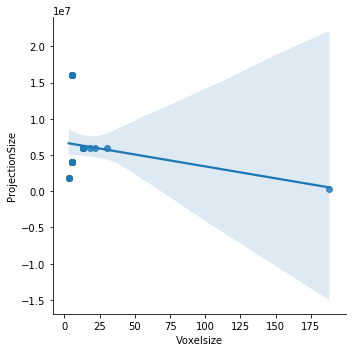

In [55]:
# Convert timedelta to minutes for plotting
# https://stackoverflow.com/a/54729327/323100
# plt.scatter(x=Data['Scan time'].astype('timedelta64[s]') / 3600,
#             y=Data['ProjectionSize']*1e-6)
seaborn.lmplot(data=Data,
               x='Voxelsize',
               y='ProjectionSize'
              )
# plt.ylabel('Projection size [MPx]')
# plt.xlabel('Scan time [h]')
plt.savefig('Scanningtime.png')
plt.show()

In [56]:
Data['PreviewImagePath'] = [sorted(glob.glob(os.path.join(f, '*_spr.bmp'))) for f in Data['Folder']]
Data['PreviewImage'] = [imageio.imread(pip[0])
                        if pip
                        else numpy.random.random((100, 100)) for pip in Data['PreviewImagePath']]

In [57]:
# Make an approximately square overview image
lines = int(numpy.ceil(len(Data)**.5))

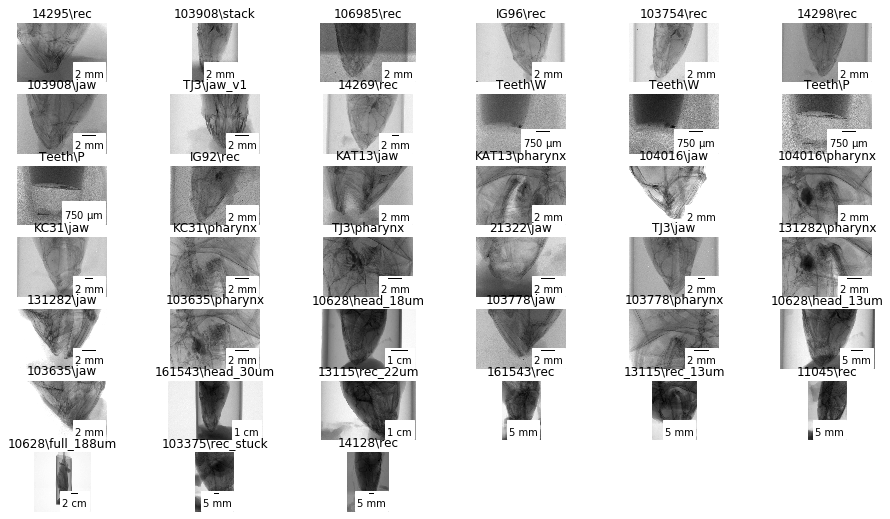

In [58]:
for c, row in Data.iterrows():
    plt.subplot(lines, numpy.ceil(len(Data) / float(lines)), c + 1)
    plt.imshow(row.PreviewImage)
    plt.title(os.path.join(row['Fish'], row['Scan']))
    plt.gca().add_artist(ScaleBar(row['Voxelsize'],
                                  'um',
                                  color='black',
                                  frameon=True))
    plt.axis('off')
# plt.tight_layout(h_pad=0.5, w_pad=0.5)
# plt.savefig(os.path.join(OutPutDir, 'ScanOverviews.png'),
#             bbox_inches='tight')
plt.show()

In [59]:
# Convert all reconstructions into a DASK array and save them to disk
# Partially based on http://stackoverflow.com/a/39195332/323100
# and on /LungMetastasis/HighResolutionScanAnalysis.ipynb
Data['OutputNameRec'] = [os.path.join(os.path.dirname(f),
                                      fish + '_' + scan + '.zarr') for f, fish, scan in zip(Data.Folder,
                                                                                                Data.Fish,
                                                                                                Data.Scan)]
for c, row in notebook.tqdm(Data.iterrows(),
                            desc='Converting reconstructions to .zarr',
                            total=len(Data)):
    if not os.path.exists(row['OutputNameRec']):
        print('%2s/%2s: Reading %s reconstructions and saving to %s' % (c + 1,
                                                                        len(Data),
                                                                        row['Number of reconstructions'],
                                                                        row['OutputNameRec'][len(Root)+1:]))
        Reconstructions = dask_image.imread.imread(os.path.join(row['Folder'], '*rec*.png'))
        Reconstructions.to_zarr(row['OutputNameRec'],
                                overwrite=True,
                                compressor=Blosc(cname='zstd',
                                                 clevel=3,
                                                 shuffle=Blosc.BITSHUFFLE))

In [60]:
# for file in Data['OutputNameRec']:
#     print(file)
#     dask.array.from_zarr(file)

In [61]:
# Load the reconstructions as zarr arrays
Reconstructions = [dask.array.from_zarr(file) for file in Data['OutputNameRec']]

In [62]:
# How big are the datasets?
Data['Size'] = [rec.shape for rec in Reconstructions]

In [63]:
# The three cardinal directions
directions = ['Axial',
              'Coronal',
              'Sagittal']

In [64]:
# Read or calculate the middle slices, put them into the dataframe and save them to disk
for d, direction in enumerate(directions):
    Data['Mid_' + direction] = [None] * len(Reconstructions)
for c, row in notebook.tqdm(Data.iterrows(), desc='Middle images', total=len(Data)):
    for d, direction in notebook.tqdm(enumerate(directions),
                                      desc='Fish %s' % row['Fish'],
                                      leave=False,
                                      total=len(directions)):
        outfilepath = os.path.join(os.path.dirname(row['Folder']),
                                   '%s.%s.Middle.%s.png' % (row['Fish'],
                                                            row['Scan'],
                                                            direction))
        if os.path.exists(outfilepath):
            Data.at[c, 'Mid_' + direction] = imageio.imread(outfilepath)
        else:
            # Generate requested axial view
            if 'Axial' in direction:
                Data.at[c, 'Mid_' + direction] = Reconstructions[c][Data['Size'][c][0] // 2].compute()
            if 'Sagittal' in direction:
                Data.at[c, 'Mid_' + direction] = Reconstructions[c][:, Data['Size'][c][1] // 2, :].compute()
            if 'Coronal' in direction:
                Data.at[c, 'Mid_' + direction] = Reconstructions[c][:, :, Data['Size'][c][2] // 2].compute()
            # Save the calculated 'direction' view to disk
            imageio.imwrite(outfilepath, (Data.at[c, 'Mid_' + direction]))

In [65]:
# Show middle slices
for c, row in notebook.tqdm(Data.iterrows(),
                            desc='Saving middle images overview',
                            total=len(Data)):
    outfilepath = os.path.join(os.path.dirname(row['Folder']),
                               '%s.%s.MiddleSlices.png' % (row['Fish'], row['Scan']))
    if not os.path.exists(outfilepath):    
        for d, direction in notebook.tqdm(enumerate(directions),
                                          desc=row['Fish'],
                                          leave=False,
                                          total=len(directions)):
            plt.subplot(1, 3, d + 1)
            plt.imshow(row['Mid_' + direction])
            if d == 0:
                plt.axhline(row.Size[1] // 2, c=seaborn.color_palette()[0])
                plt.axvline(row.Size[2] // 2, c=seaborn.color_palette()[1])
                plt.gca().add_artist(ScaleBar(row['Voxelsize'],
                                              'um',
                                              color=seaborn.color_palette()[2]))
            elif d == 1:
                plt.axhline(row.Size[0] // 2, c=seaborn.color_palette()[2])
                plt.axvline(row.Size[d] // 2, c=seaborn.color_palette()[1])
                plt.gca().add_artist(ScaleBar(row['Voxelsize'],
                                              'um',
                                              color=seaborn.color_palette()[0]))
            else:
                plt.axhline(row.Size[0] // 2, c=seaborn.color_palette()[2])
                plt.axvline(row.Size[d] // 2, c=seaborn.color_palette()[0])
                plt.gca().add_artist(ScaleBar(row['Voxelsize'],
                                              'um',
                                              color=seaborn.color_palette()[1]))
            plt.title('%s, %s' % (os.path.join(row['Fish'], row['Scan']),
                                  direction + ' Middle slice'))
            plt.axis('off')
            plt.savefig(outfilepath,
                        transparent=True,
                        bbox_inches='tight')
        plt.show()

In [66]:
# Read or calculate the directional MIPs, put them into the dataframe and save them to disk
for d, direction in enumerate(directions):
    Data['MIP_' + direction] = [None] * len(Reconstructions)
for c, row in notebook.tqdm(Data.iterrows(), desc='MIPs', total=len(Data)):
    for d, direction in notebook.tqdm(enumerate(directions),
                                      desc='%s' % row['Fish'],
                                      leave=False,
                                      total=len(directions)):
        outfilepath = os.path.join(os.path.dirname(row['Folder']),
                                   '%s.%s.MIP.%s.png' % (row['Fish'],
                                                      row['Scan'],
                                                      direction))
        if os.path.exists(outfilepath):
            Data.at[c, 'MIP_' + direction] = imageio.imread(outfilepath)
        else:
            # Generate MIP
            Data.at[c, 'MIP_' + direction] = Reconstructions[c].max(axis=d).compute()
            # Save it out
            imageio.imwrite(outfilepath, Data.at[c, 'MIP_' + direction].astype('uint8'))

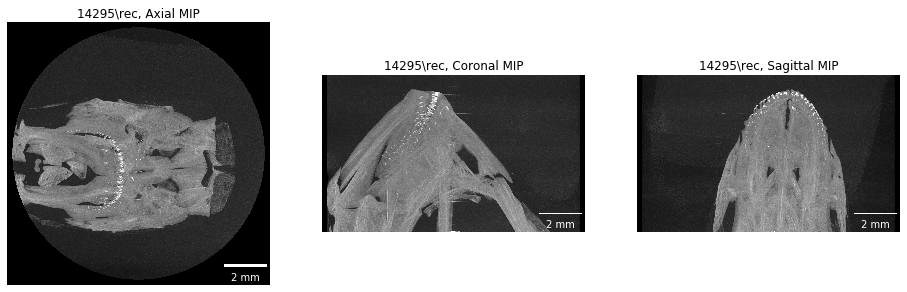

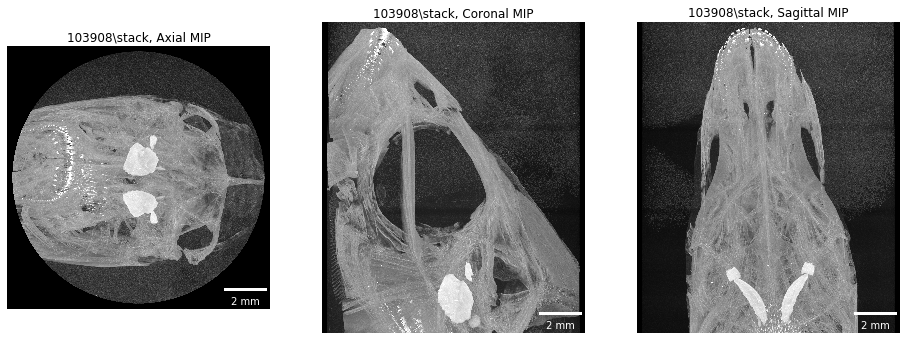

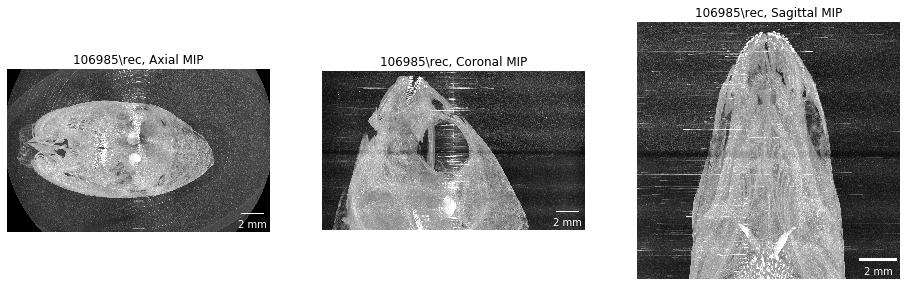

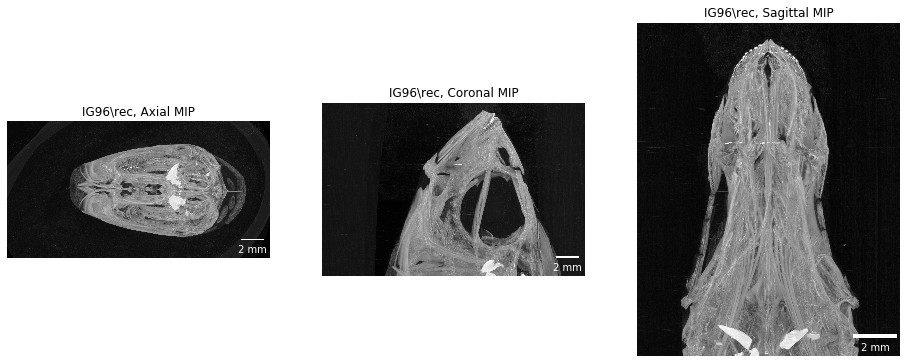

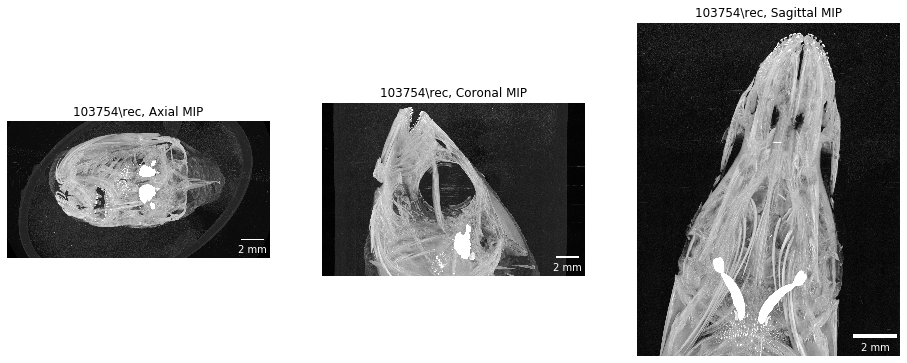

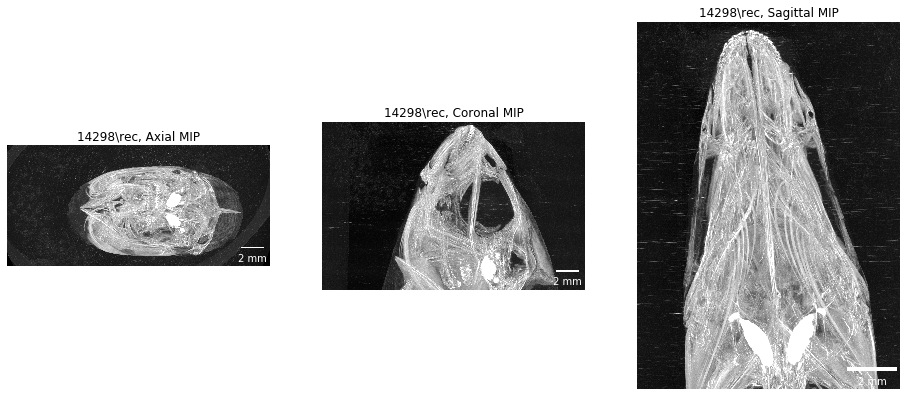

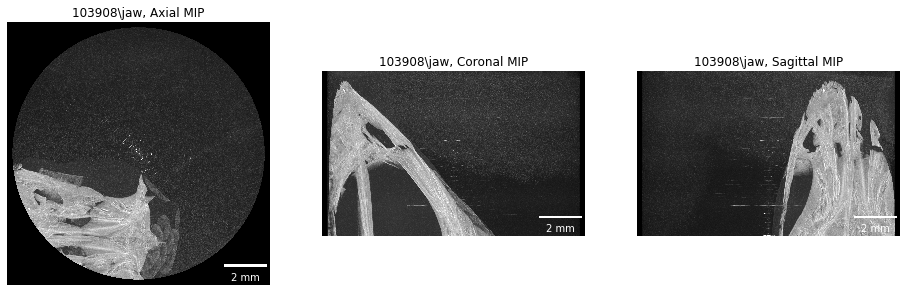

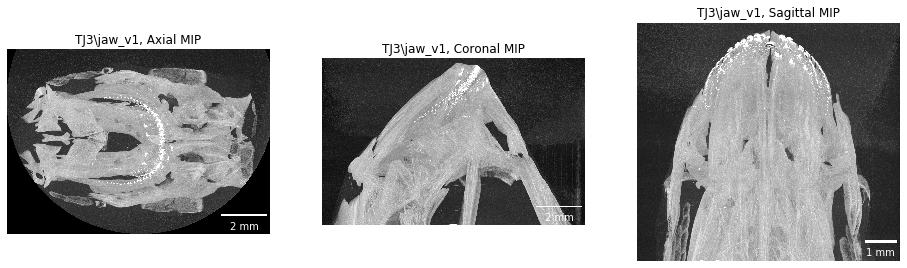

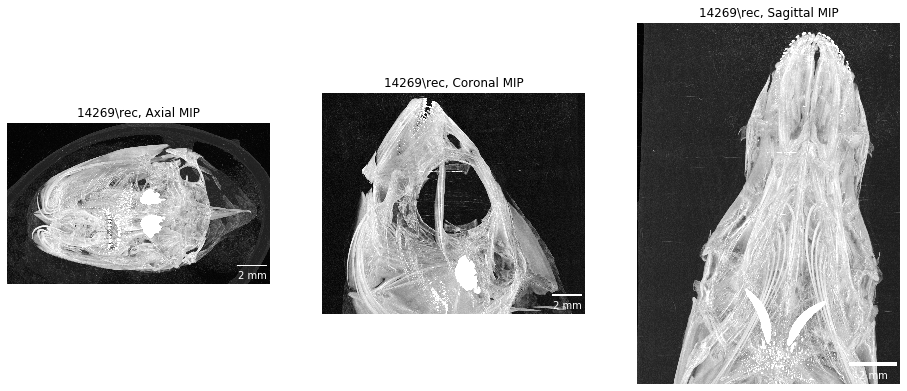

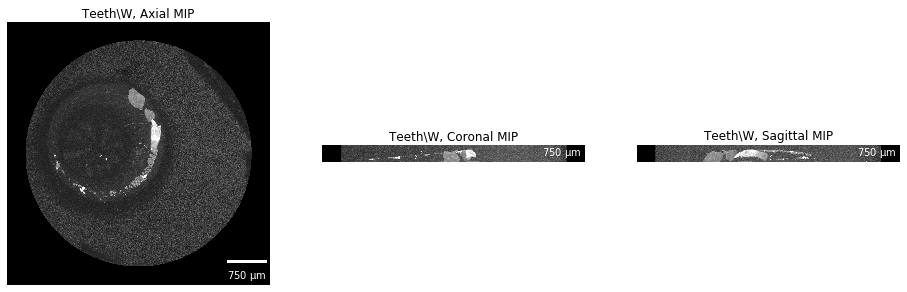

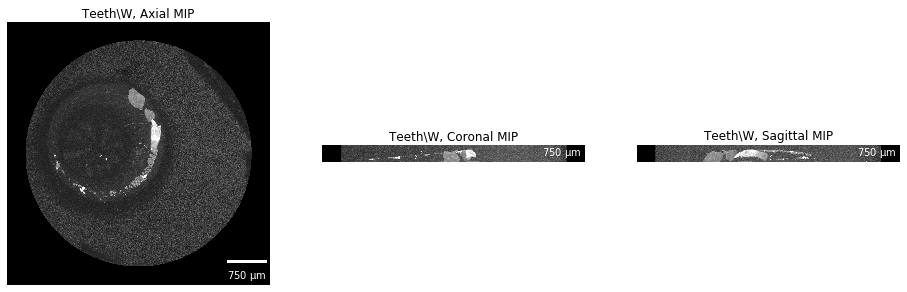

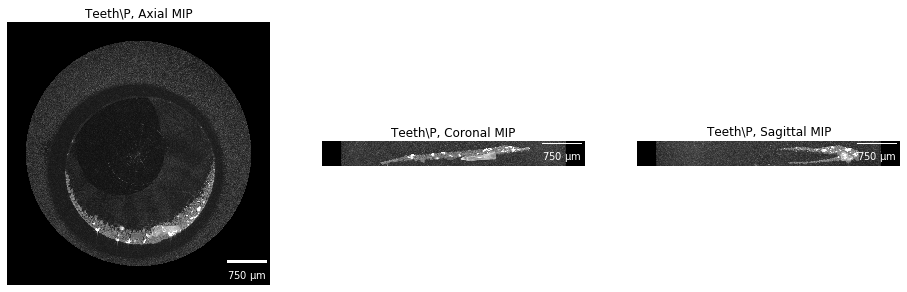

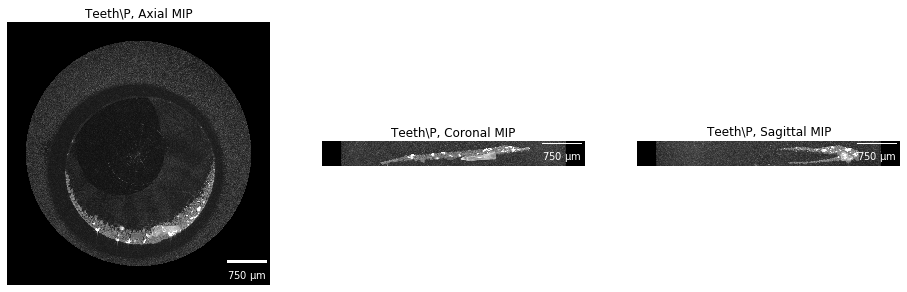

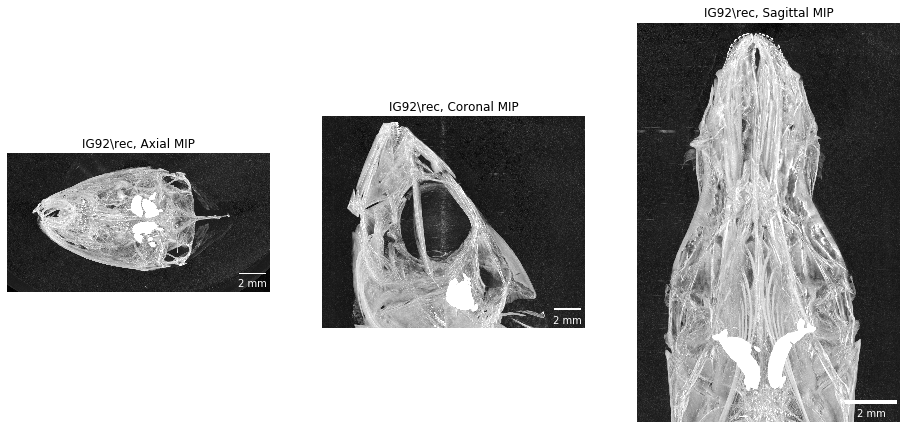

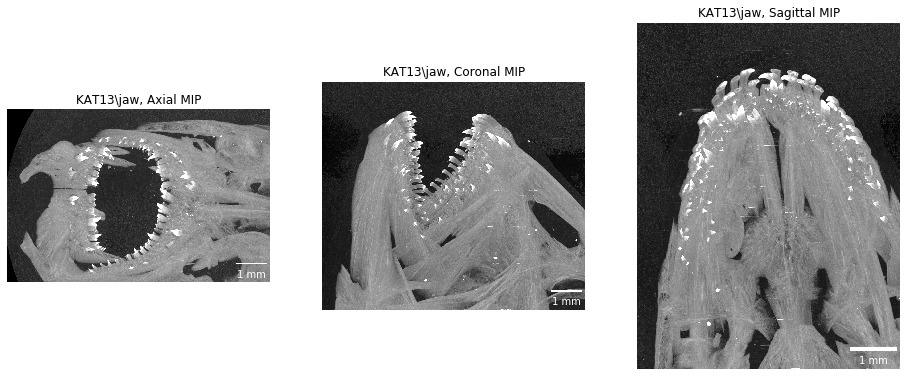

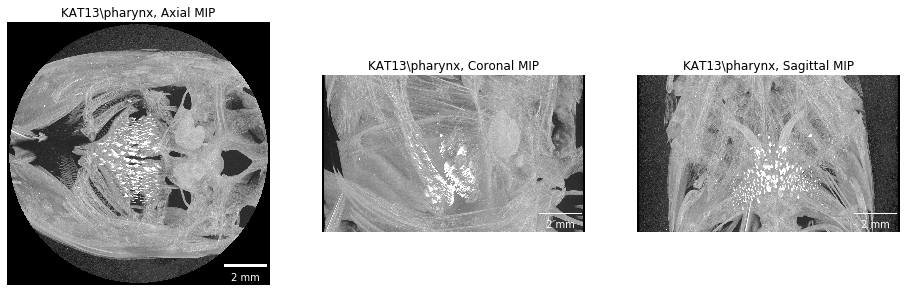

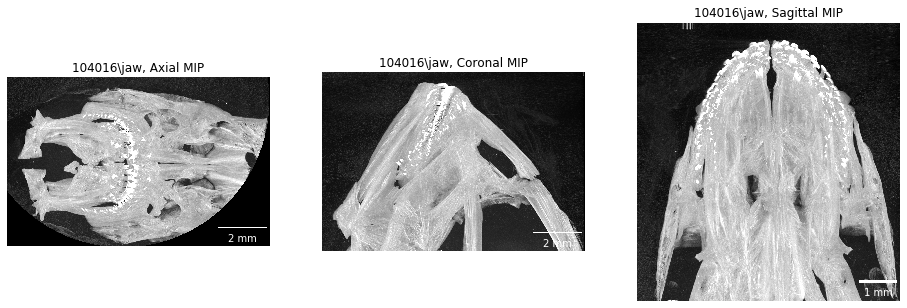

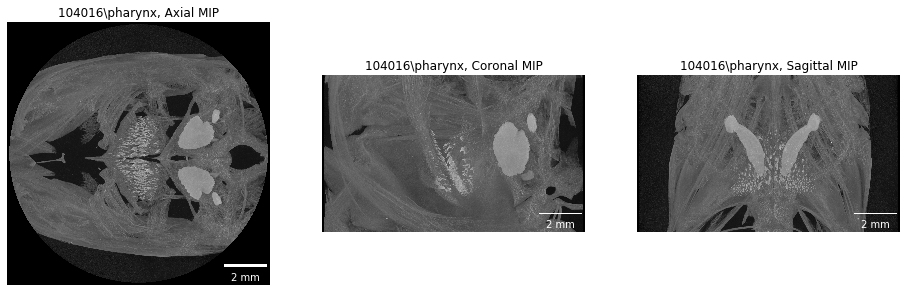

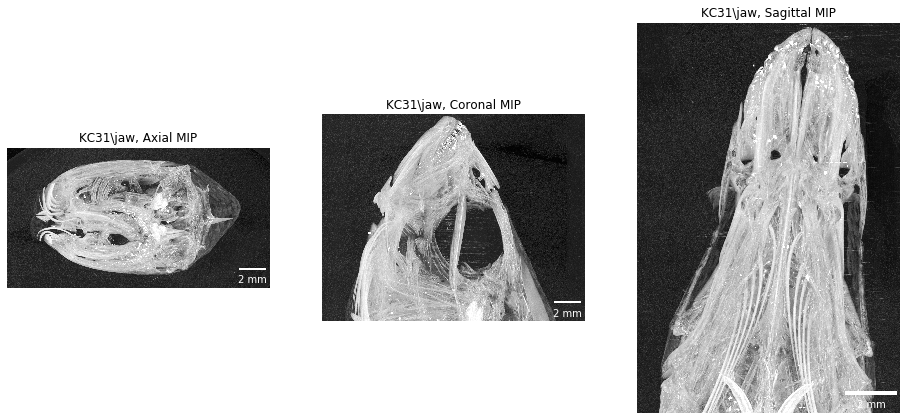

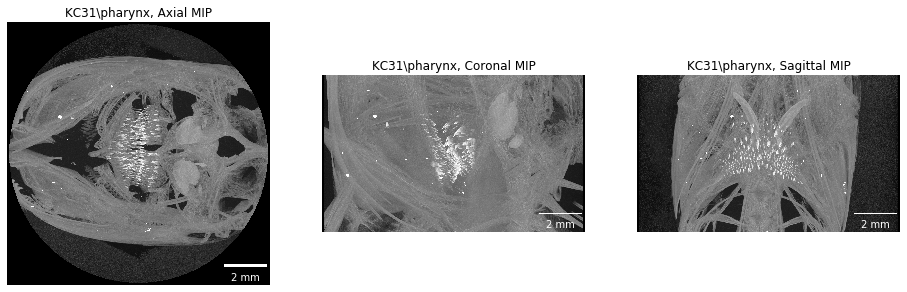

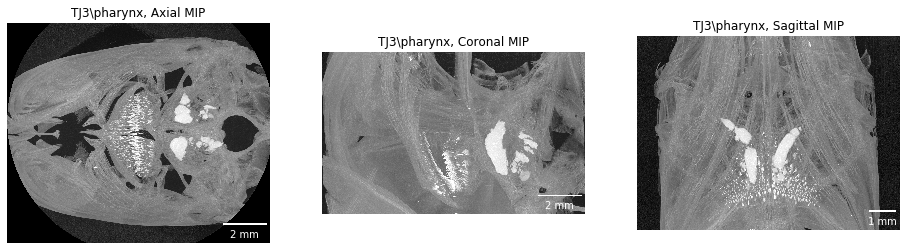

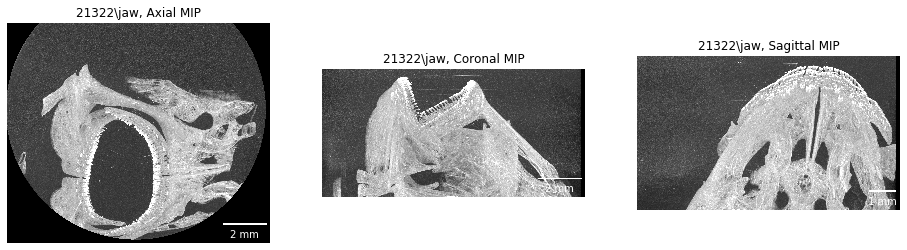

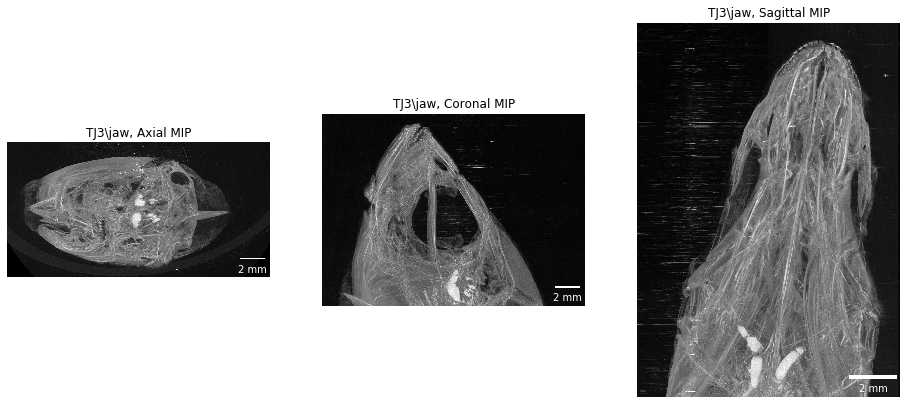

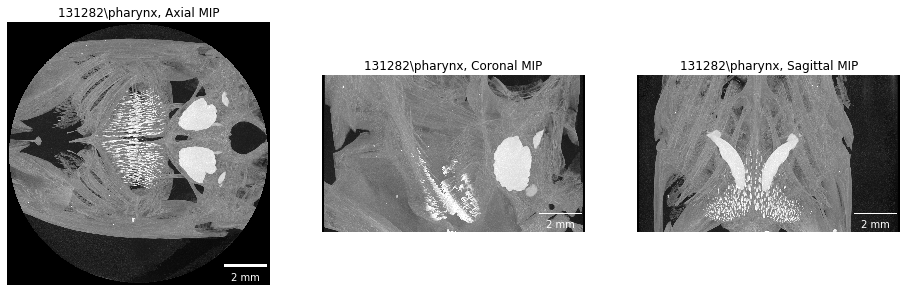

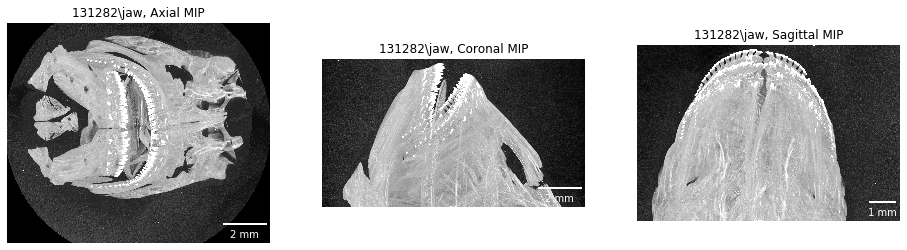

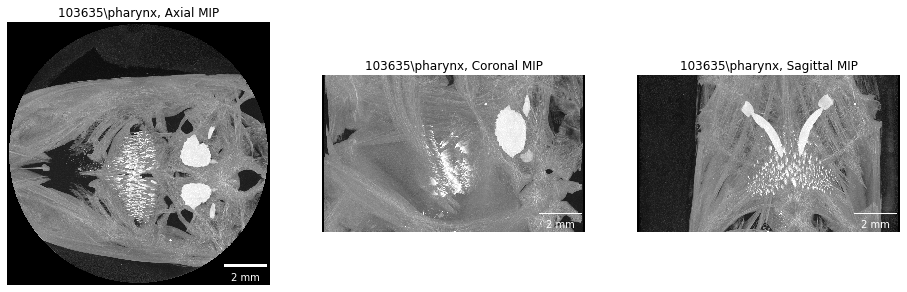

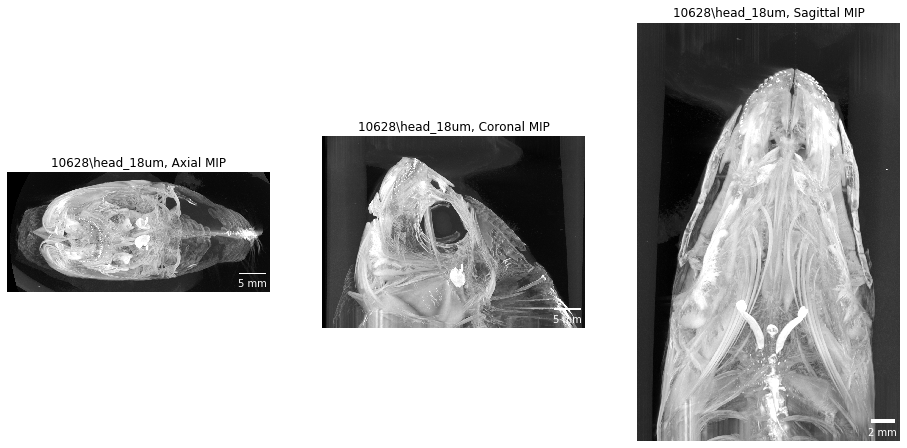

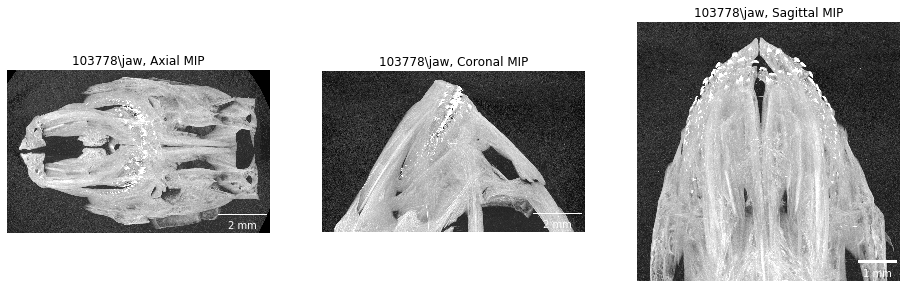

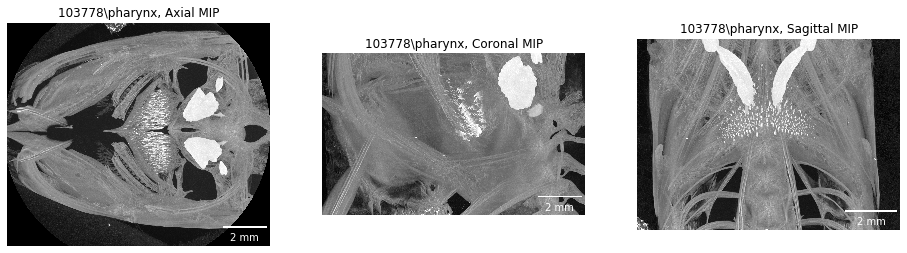

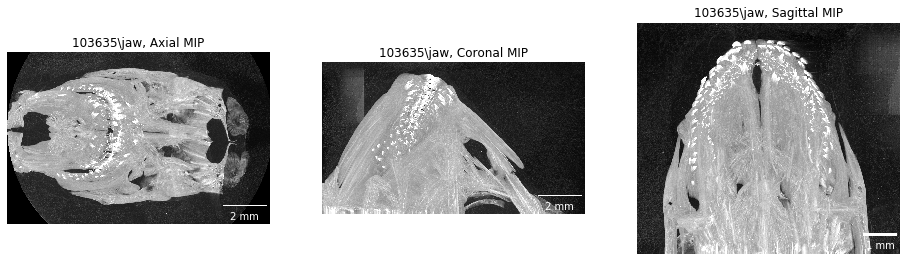

In [67]:
# Show MIP slices
for c, row in notebook.tqdm(Data.iterrows(), desc='Saving MIP images overview', total=len(Data)):
    outfilepath = os.path.join(os.path.dirname(row['Folder']),
                               '%s.%s.MIPs.png' % (row['Fish'], row['Scan']))
    if os.path.exists(outfilepath):    
        for d, direction in notebook.tqdm(enumerate(directions),
                                          desc=row['Fish'],
                                          leave=False,
                                          total=len(directions)):
            plt.subplot(1, 3, d + 1)
            plt.imshow(row['MIP_' + direction])
            plt.gca().add_artist(ScaleBar(row['Voxelsize'],
                                          'um'))
            plt.title('%s, %s' % (os.path.join(row['Fish'], row['Scan']),
                                  direction + ' MIP'))
            plt.axis('off')
        if not os.path.exists(outfilepath):
            plt.savefig(outfilepath,
                        transparent=True,
                        bbox_inches='tight')
        plt.show()

In [69]:
print('At the moment, we have %s datasets' % len(Data))

At the moment, we have 39 datasets
